In [1]:
!pip install torch pandas scikit-learn numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [3]:
def load_separate_datasets(train_path, test_path):
    """Load and preprocess train/test data"""
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    print(f"[INFO] Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    
    # Detect label column
    label_col = 'class' if 'class' in train_df.columns else 'label' if 'label' in train_df.columns else 'attack'
    print(f"[INFO] Using label column: {label_col}")
    
    # Convert categorical to strings
    for col in train_df.columns:
        if isinstance(train_df[col].dtype, pd.CategoricalDtype):
            train_df[col] = train_df[col].astype(str)
            test_df[col] = test_df[col].astype(str)
    
    # Fill missing values
    train_df = train_df.fillna("missing")
    test_df = test_df.fillna("missing")
    
    # Encode categorical columns
    label_encoders = {}
    for col in train_df.columns:
        if train_df[col].dtype == 'object':
            le = LabelEncoder()
            train_df[col] = le.fit_transform(train_df[col].astype(str))
            test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            le.classes_ = np.append(le.classes_, 'unknown')
            test_df[col] = le.transform(test_df[col].astype(str))
            label_encoders[col] = le
    
    # Separate features and labels
    drop_cols = [c for c in ['attack_cat', 'label', 'classnum', 'class', 'type', 'attack', 'category', 'subcategory'] if c in train_df.columns]
    X_train = train_df.drop(columns=drop_cols).values
    y_train = train_df[label_col].values
    X_test = test_df.drop(columns=drop_cols).values
    y_test = test_df[label_col].values
    
    # Binary: Normal (0) vs Anomaly (1)
    y_train_binary = np.where(y_train == y_train.min(), 0, 1)
    y_test_binary = np.where(y_test == y_test.min(), 0, 1)
    
    print(f"[INFO] Binary distribution (train): {np.unique(y_train_binary, return_counts=True)}")
    print(f"[INFO] Binary distribution (test): {np.unique(y_test_binary, return_counts=True)}")
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_binary, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_binary, dtype=torch.float32)
    
    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds = TensorDataset(X_test_t, y_test_t)
    
    print(f"[INFO] Features: {X_train.shape[1]}, Train: {len(train_ds)}, Test: {len(test_ds)}\n")
    
    return train_ds, test_ds, X_train.shape[1], X_train_t, y_train_t, X_test_t, y_test_t

In [4]:
class DenseNet(nn.Module):
    """Phase I: DenseNet for Normal vs Anomaly"""
    def __init__(self, input_dim):
        super(DenseNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    
    def forward(self, x):
        attn_out, _ = self.attention(x, x, x)
        return attn_out

In [6]:
class DeepNet(nn.Module):
    """Phase II: DeepNet (Bi-LSTM + Attention)"""
    def __init__(self, input_dim, hidden_dim=128, num_heads=4):
        super(DeepNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_dim * 2, num_heads)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        pooled = attn_out.mean(dim=1)
        return self.fc(pooled)

In [7]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=15):
    """Train model"""
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

In [8]:
def get_phase1_anomalies(phase1_model, X_train, y_train, X_test, y_test, device):
    """Extract anomalies predicted by Phase I for Phase II training"""
    phase1_model.eval()
    
    # Get Phase I predictions on training data
    with torch.no_grad():
        X_train_dev = X_train.to(device)
        train_preds = phase1_model(X_train_dev).squeeze().cpu().numpy()
        train_anomaly_mask = (train_preds > 0.5)
    
    # Filter to anomalies only
    X_train_anomalies = X_train[train_anomaly_mask]
    y_train_anomalies = y_train[train_anomaly_mask]
    
    print(f"\n[INFO] Phase I predicted {train_anomaly_mask.sum()} anomalies out of {len(X_train)} training samples")
    print(f"[INFO] Creating Phase II dataset with {len(X_train_anomalies)} anomaly samples")
    
    # Create Phase II training dataset
    phase2_train_ds = TensorDataset(X_train_anomalies, y_train_anomalies)
    
    # For test: get Phase I predictions
    with torch.no_grad():
        X_test_dev = X_test.to(device)
        test_preds = phase1_model(X_test_dev).squeeze().cpu().numpy()
        test_anomaly_mask = (test_preds > 0.5)
    
    return phase2_train_ds, test_anomaly_mask, train_preds, test_preds

In [37]:
def evaluate_phase1(phase1_model, test_loader, device):
    """Evaluate Phase I"""
    phase1_model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = phase1_model(X_batch).squeeze()
            preds = (outputs.cpu().numpy() > 0.5).astype(int)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    FP = cm[0, 1] if cm.shape[0] > 1 else 0
    TN = cm[0, 0] if cm.shape[0] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TP = cm[1, 1] if cm.shape[0] > 1 else 0
    
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    print(f"\n{'='*60}")
    print("PHASE I EVALUATION")
    print(f"{'='*60}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'], digits=4))
    print(f"\n[METRICS]")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"FPR:       {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"{'='*60}\n")
    
    return y_pred, acc, fpr, cm

In [33]:
def evaluate_cascade(phase1_model, phase2_model, X_test, y_test, device):
    """Evaluate cascade: Phase I → Phase II (only for anomalies)"""
    phase1_model.eval()
    phase2_model.eval()
    
    y_true = y_test.numpy()
    final_predictions = np.zeros(len(y_test), dtype=int)
    
    with torch.no_grad():
        X_test_dev = X_test.to(device)
        
        # Step 1: Phase I predictions
        phase1_preds = phase1_model(X_test_dev).squeeze().cpu().numpy()
        phase1_binary = (phase1_preds > 0.5).astype(int)
        
        # Step 2: For samples Phase I classified as Normal (0), keep as Normal
        final_predictions[phase1_binary == 0] = 0
        
        # Step 3: For samples Phase I classified as Anomaly (1), run Phase II
        anomaly_indices = np.where(phase1_binary == 1)[0]
        
        if len(anomaly_indices) > 0:
            X_anomalies = X_test[anomaly_indices].to(device)
            phase2_preds = phase2_model(X_anomalies).squeeze().cpu().numpy()
            phase2_binary = (phase2_preds > 0.5).astype(int)
            
            # Phase II refines: can reclassify as Normal (0) or confirm Anomaly (1)
            final_predictions[anomaly_indices] = phase2_binary
    
    # Evaluate final cascade predictions
    acc = accuracy_score(y_true, final_predictions)
    cm = confusion_matrix(y_true, final_predictions)
    
    FP = cm[0, 1] if cm.shape[0] > 1 else 0
    TN = cm[0, 0] if cm.shape[0] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TP = cm[1, 1] if cm.shape[0] > 1 else 0
    
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    print(f"\n{'='*60}")
    print("CASCADE EVALUATION (Phase I → Phase II)")
    print(f"{'='*60}")
    print(f"[INFO] Phase I sent {len(anomaly_indices)} samples to Phase II")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, final_predictions, target_names=['Normal', 'Anomaly'], digits=4))
    print(f"\n[METRICS]")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"FPR:       {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"{'='*60}\n")
    
    return acc, fpr, cm

In [22]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", figsize=(6,6), annotate=True, fmt="d", fontsize=12, save_path=None):
    """
    Plot a confusion matrix (numpy array) with matplotlib.
    - cm: 2x2 (or NxN) confusion matrix (numpy array)
    - class_names: list of class names in order (e.g. ['Normal','Anomaly'])
    """
    cm = np.array(cm)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap='Blues')   # default colormap
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, class_names, fontsize=fontsize)

    # Annotate cells
    if annotate:
        thresh = cm.max() / 2.0 if cm.max() > 0 else 0.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=fontsize,
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label", fontsize=fontsize)
    plt.xlabel("Predicted label", fontsize=fontsize)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

In [12]:
TRAIN_PATH = "dataset/train/KDDTrain.parquet"
TEST_PATH = "dataset/test/KDDTest.parquet"
BATCH_SIZE = 128
EPOCHS = 15
LR = 0.001
class_names = ['Normal', 'Anomaly']

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}\n")

[INFO] Using device: cuda



In [14]:
train_ds, test_ds, input_dim, X_train, y_train, X_test, y_test = load_separate_datasets(TRAIN_PATH, TEST_PATH)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

[INFO] Train shape: (125973, 38), Test shape: (22544, 38)
[INFO] Using label column: class
[INFO] Binary distribution (train): (array([0, 1]), array([   956, 125017]))
[INFO] Binary distribution (test): (array([0, 1]), array([  359, 22185]))
[INFO] Features: 36, Train: 125973, Test: 22544



In [15]:
print("PHASE I: DenseNet Training")
phase1_model = DenseNet(input_dim).to(device)
criterion = nn.BCELoss()
optimizer1 = optim.Adam(phase1_model.parameters(), lr=LR, weight_decay=1e-5)

train_model(phase1_model, train_loader, criterion, optimizer1, device, EPOCHS)

PHASE I: DenseNet Training
Epoch [1/15] Loss: 0.0450
Epoch [2/15] Loss: 0.0047
Epoch [3/15] Loss: 0.0037
Epoch [4/15] Loss: 0.0035
Epoch [5/15] Loss: 0.0031
Epoch [6/15] Loss: 0.0030
Epoch [7/15] Loss: 0.0028
Epoch [8/15] Loss: 0.0030
Epoch [9/15] Loss: 0.0025
Epoch [10/15] Loss: 0.0024
Epoch [11/15] Loss: 0.0025
Epoch [12/15] Loss: 0.0023
Epoch [13/15] Loss: 0.0023
Epoch [14/15] Loss: 0.0023
Epoch [15/15] Loss: 0.0022



PHASE I EVALUATION
Confusion Matrix:
[[  341    18]
 [    3 22182]]

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9913    0.9499    0.9701       359
     Anomaly     0.9992    0.9999    0.9995     22185

    accuracy                         0.9991     22544
   macro avg     0.9952    0.9749    0.9848     22544
weighted avg     0.9991    0.9991    0.9991     22544


[METRICS]
Accuracy:  0.9991 (99.91%)
Precision: 0.9992
Recall:    0.9999
FPR:       0.0501 (5.01%)



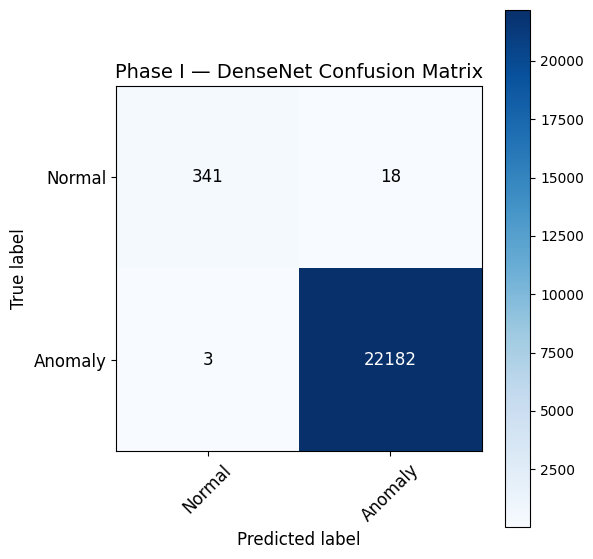

[SAVED] phase1_densenet.pth



In [38]:
_, acc1, fpr1, cm1 = evaluate_phase1(phase1_model, test_loader, device)

plot_confusion_matrix(cm1, class_names, title="Phase I — DenseNet Confusion Matrix", save_path="model/KDD/cm_phase1.png")

torch.save(phase1_model.state_dict(), "model/KDD/phase1_densenet.pth")
print("[SAVED] phase1_densenet.pth\n")

In [17]:
print("EXTRACTING ANOMALIES FROM PHASE I")
phase2_train_ds, test_anomaly_mask, _, _ = get_phase1_anomalies(
    phase1_model, X_train, y_train, X_test, y_test, device
)

phase2_train_loader = DataLoader(phase2_train_ds, batch_size=BATCH_SIZE, shuffle=True)

EXTRACTING ANOMALIES FROM PHASE I

[INFO] Phase I predicted 125001 anomalies out of 125973 training samples
[INFO] Creating Phase II dataset with 125001 anomaly samples


In [18]:
print("PHASE II: DeepNet Training")
phase2_model = DeepNet(input_dim).to(device)
optimizer2 = optim.Adam(phase2_model.parameters(), lr=LR, weight_decay=1e-5)

train_model(phase2_model, phase2_train_loader, criterion, optimizer2, device, EPOCHS)

PHASE II: DeepNet Training
Epoch [1/15] Loss: 0.0382
Epoch [2/15] Loss: 0.0016
Epoch [3/15] Loss: 0.0011
Epoch [4/15] Loss: 0.0010
Epoch [5/15] Loss: 0.0011
Epoch [6/15] Loss: 0.0010
Epoch [7/15] Loss: 0.0011
Epoch [8/15] Loss: 0.0010
Epoch [9/15] Loss: 0.0010
Epoch [10/15] Loss: 0.0011
Epoch [11/15] Loss: 0.0010
Epoch [12/15] Loss: 0.0025
Epoch [13/15] Loss: 0.0010
Epoch [14/15] Loss: 0.0010
Epoch [15/15] Loss: 0.0010


In [19]:
torch.save(phase2_model.state_dict(), "model/KDD/phase2_deepnet.pth")
print("\n[SAVED] phase2_deepnet.pth\n")


[SAVED] phase2_deepnet.pth



EVALUATING CASCADE SYSTEM

CASCADE EVALUATION (Phase I → Phase II)
[INFO] Phase I sent 22200 samples to Phase II

Confusion Matrix:
[[  341    18]
 [    3 22182]]

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9913    0.9499    0.9701       359
     Anomaly     0.9992    0.9999    0.9995     22185

    accuracy                         0.9991     22544
   macro avg     0.9952    0.9749    0.9848     22544
weighted avg     0.9991    0.9991    0.9991     22544


[METRICS]
Accuracy:  0.9991 (99.91%)
Precision: 0.9992
Recall:    0.9999
FPR:       0.0501 (5.01%)



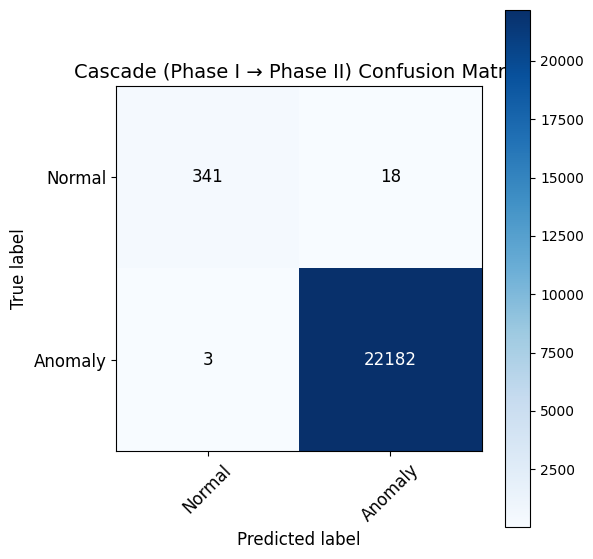

In [39]:
print("EVALUATING CASCADE SYSTEM")
acc_cascade, fpr_cascade, cm_cascade = evaluate_cascade(phase1_model, phase2_model, X_test, y_test, device)
plot_confusion_matrix(cm_cascade, class_names, title="Cascade (Phase I → Phase II) Confusion Matrix", save_path="model/KDD/cm_cascade.png")

In [40]:
print(f"Phase I (DenseNet)     → Acc: {acc1:.4f} ({acc1*100:.2f}%) | FPR: {fpr1:.4f} ({fpr1*100:.2f}%)")
print(f"Cascade (I → II)       → Acc: {acc_cascade:.4f} ({acc_cascade*100:.2f}%) | FPR: {fpr_cascade:.4f} ({fpr_cascade*100:.2f}%)")

Phase I (DenseNet)     → Acc: 0.9991 (99.91%) | FPR: 0.0501 (5.01%)
Cascade (I → II)       → Acc: 0.9991 (99.91%) | FPR: 0.0501 (5.01%)
